# Chargement de données dans TensorFlow 2.0

Ce notebook présente comment charger des fichiers de différent types dans TensorFlow 2.0.  
Les types de fichiers traités dans le notebook sont les suivants:

1. Tensor
2. Fichier CSV
3. Images

Pour charger un fichier dans TensorFlow, il faut utiliser l'API `tf.data.Dataset`

## Chargement des bibliothèques utiles

In [28]:
import os
import pathlib
import numpy as np
import pandas as pd 
from PIL import Image
import tensorflow as tf
from functools import partial
import matplotlib.pyplot as plt
import IPython.display as display


print('TensorFlow vertion: ', tf.version.VERSION )

TensorFlow vertion:  2.1.0


In [270]:
# Améliorer la lecture des valeures numpy
# (precision=3) Limiter à 3 les chiffres après la virgule
# (suppress=True) Supprimer la notation scientifique

np.set_printoptions(precision=3, suppress=True)

# Tensor

Charger les données d'un tensor dans TensorFlow avec `.from_tensors`et `.from_tensor_slices`

In [280]:
def show_data(dataset):
    for elem in dataset:
        print(elem.numpy())
    
# 2D Tensor (Rank-2)
t1 = tf.constant([[2, 3], [3, 5]])
# .from_tensorsCréer un dataset contenant seulement un élément
ds1 = tf.data.Dataset.from_tensors(t)

# 2D Tensor (Rank-2)
t2 = tf.constant([[2, 3], [3, 5]])
# .from_tensor_slices créer un dataset contennant autant d'éléments que lignes qui le composent 
ds2 = tf.data.Dataset.from_tensor_slices(t)

print('.from_tensors:')
show_data(ds1)
print()
print('.from_tensor_slice:')
show_data(ds2)

.from_tensors:
[[2 3]
 [3 5]]

.from_tensor_slice:
[2 3]
[3 5]


# Fichier CSV

1. Charger les données dans TensorFlow à partir d'un dataframe pandas.
2. Charger les données d'un fichier csv en utilisant l'API `experimental.make_csv_datase`.

### Analyser les données avant de les charger dans TensorFlow

- Les données utilisées sont issues des logements Parisiens disposant d'un encadrement de loyer.  
Dans cet exemple le but est de prédire le loyer (ref) d'un appartement en fonction du nombre de pièce, époque, le quartier et la zone.

Explorer les données avant de les importer dans TensorFlow.

In [284]:
file_path = './data/logement-encadrement-des-loyers.csv'
df = pd.read_csv(file_path, sep=';' )
df.head()

,id_zone,id_quartier,nom_quartier,piece,epoque,meuble_txt,ref,max,min,annee,ville,code_grand_quartier,geo_shape,geo_point_2d
0,11,77,Belleville,4,Avant 1946,non meublé,21.4,25.68,14.98,2020,PARIS,7512077,"{""type"": ""Polygon"", ""coordinates"": [[[2.383226...","48.8715312006,2.38754923985"
1,13,75,Amérique,3,1971-1990,non meublé,16.7,20.04,11.69,2020,PARIS,7511975,"{""type"": ""Polygon"", ""coordinates"": [[[2.409402...","48.8816381673,2.39544016662"
2,13,74,Pont-de-Flandre,2,1971-1990,meublé,20.2,24.24,14.14,2020,PARIS,7511974,"{""type"": ""Polygon"", ""coordinates"": [[[2.384878...","48.8955557746,2.38477722927"
3,13,75,Amérique,1,1971-1990,meublé,24.0,28.80,16.80,2020,PARIS,7511975,"{""type"": ""Polygon"", ""coordinates"": [[[2.409402...","48.8816381673,2.39544016662"
4,13,78,Saint-Fargeau,1,Avant 1946,meublé,29.4,35.28,20.58,2020,PARIS,7512078,"{""type"": ""Polygon"", ""coordinates"": [[[2.413813...","48.8710347391,2.40617153015"


In [285]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2560 entries, 0 to 2559
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id_zone              2560 non-null   int64  
 1   id_quartier          2560 non-null   int64  
 2   nom_quartier         2560 non-null   object 
 3   piece                2560 non-null   int64  
 4   epoque               2560 non-null   object 
 5   meuble_txt           2560 non-null   object 
 6   ref                  2560 non-null   float64
 7   max                  2560 non-null   float64
 8   min                  2560 non-null   float64
 9   annee                2560 non-null   int64  
 10  ville                2560 non-null   object 
 11  code_grand_quartier  2560 non-null   int64  
 12  geo_shape            2560 non-null   object 
 13  geo_point_2d         2560 non-null   object 
dtypes: float64(3), int64(5), object(6)
memory usage: 280.1+ KB


In [286]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
id_zone,2560.0,6.662500e+00,4.225585,1.00,3.00,5.00,11.00,14.00
id_quartier,2560.0,4.050000e+01,23.096718,1.00,20.75,40.50,60.25,80.00
piece,2560.0,2.500000e+00,1.118252,1.00,1.75,2.50,3.25,4.00
ref,2560.0,2.572723e+01,4.181951,14.60,22.90,25.30,28.30,39.60
max,2560.0,3.087267e+01,5.018341,17.52,27.48,30.36,33.96,47.52
min,2560.0,1.800906e+01,2.927365,10.22,16.03,17.71,19.81,27.72
annee,2560.0,2.020000e+03,0.000000,2020.00,2020.00,2020.00,2020.00,2020.00
code_grand_quartier,2560.0,7.511090e+06,599.811459,7510101.00,7510595.75,7511090.50,7511585.25,7512080.00


In [303]:
from sklearn.model_selection import train_test_split

test, train_eval = train_test_split(df, test_size=0.9, random_state=21)
eval_, train = train_test_split(train_eval, test_size=0.8, random_state=21)

print("90% pour l'entrainement et l'évaluation et 10% pour le teste")
print('Train & Eval:', len(train_eval))
print('Test        :', len(test))
print()
print("80% et 20% des 90% pour l'entrainement et l'évaluation")
print('Train       :', len(train))
print('Eval        :', len(eval_))

90% pour l'entrainement et l'évaluation et 10% pour le teste
Train & Eval: 2304
Test        : 256

80% et 20% des 90% pour l'entrainement et l'évaluation
Train       : 1844
Eval        : 460


## Créer trois jeux de données
1. Un jeux de données pour l'entrainement du model (80% des 90% de l'ensemble des données)
2. Un jeux de données pour l'évaluation du model (20% des 90% de l'ensemble des données
3. Un jeux de données pour réaliser des testes (10% de l'ensemble des donnée du fichier)

In [300]:
def df_row_to_split(df, frac):
    '''Cette fonction permet de déterminer le nombre de ligne du dataframe à retourner en fonc'''
    percent = frac * 100
    return round(df_sample.shape[0] * percent / 100)

# Mélanger les données du dataframe
df_sample = df.sample(frac=1, random_state=21).reset_index(drop=False)

# Prendre environ 90% des données pour l'entrainement et l'évaluation du model
row_nb = df_row_to_split(df, 0.9)
train_eval_data = df_sample[:row_nb].drop(['index'], axis=1)

# Prendre environ 10% des données pour tester du model sur de nouvelle données
test_data = df_sample[row_nb:].drop(['index'], axis=1)
test_data.to_csv('./data/test.csv', index=False)

# Prendre 80% des données du dataframe train_eval pour l'entrainement du model
row_nb = df_row_to_split(train_eval_data, 0.8)
train_data = train_eval_data[:row_nb]
train_data.to_csv('./data/train.csv', index=False)

# Prendre 20% des données du dataframe train_eval pour l'évaluation du model
eval_data = train_eval_data[row_nb:]
eval_data.to_csv('./data/eval.csv', index=False)


### Pré-traitement des données

Traiter les données du dataframe avant de la charger dans TensorFlow.

1. Les valeurs de la colonne `epoque` ne sont pas de type continue, elles sont de type string.  
Les données de cette colonne doivent être transformé pour pouvoir être utiliser.

2. Supprimer les colonnes non utilisées

In [333]:
def df_processed(df, features, label):
    '''Traitement des données avant le chargement dans tensorFlow'''
    
    df_processed = df.copy()
    df_processed.columns
    
    # Listes des noms des colonnes
    features_label = features + label
    # Supprimer les colonnes non utilisées
    col_to_remove = [col_name for col_name in df_processed.columns.tolist() if col_name not in features_label]
    
    return df_processed.drop(col_to_remove, axis=1)

def one_hot_encoding(df, col_names):
    '''Cette fonction permet de traiter les colonnes avec des données catégoriel
    en utilisant la methode de one-hot encoding'''
    
    for col_name in col_names:
        df[col_name] = pd.Categorical(df[col_name])
        df[col_name] = df[col_name].cat.codes
        
    return df

In [334]:
# Créer les dataframe pandas 

df_train = pd.read_csv('./data/train.csv', sep=',')
df_eval = pd.read_csv('./data/eval.csv', sep=',')
df_test = pd.read_csv('./data/test.csv', sep=',')

In [335]:
label_col_name = ['ref']
features_col_name = ['piece', 'epoque', 'id_zone', 'id_quartier'] 

# Pré-traitement du dataframe avant le chargement dans TensforFlow
df_train_processed = df_processed(df_train, features_col_name, label_col_name)
df_eval_processed = df_processed(df_eval, features_col_name, label_col_name)

# Utiliser la methode du 'One Hote Encoding' pour traiter les données de type catégoriel
df_train_processed = one_hot_encoding(df_train_processed, ['epoque'])
df_eval_processed.epoque = one_hot_encoding(df_eval_processed, ['epoque'])

df_train_processed.head(2)

,id_zone,id_quartier,piece,epoque,ref
0,9,70,1,1,24.2
1,10,44,2,2,28.0


### Charger les dataframes pandas dans TensFlow

In [331]:
def show_data(dataset, nb_row):
    '''Cette fonction permet d'afficher les exemples d'un tensor'''
    
    for feat, label in dataset.take(nb_row):
        print('Features: {}, Label: {}'.format(feat, label))

In [332]:
# Valeures à prédire 
label_train = df_train_processed.pop(label_col_name[0])
label_eval = df_eval_processed.pop(label_col_name[0])

# Charger les données dans tensorFlow avec tf.data.Dataset.from_tensor_slices
train_dataset = tf.data.Dataset.from_tensor_slices((df_train_processed.values, label_train.values))
eval_dataset = tf.data.Dataset.from_tensor_slices((df_eval_processed.values, label_eval.values))

show_data(train_dataset, 1)

Features: [ 9 70  1  1], Label: 24.2


### Mélanger les données données et créer des minis batch

Si les données non pas déjà été mélangé:
- `dataset.shuffle(len(df), seed=(21)).batch(nb_of_exemple)`

Dans notre cas les données ont déjà été mélangé précédemment.

In [344]:
# Les minis batch sont volontairement petit pour une meilleure lisibilité des exemples
train_data_set = train_dataset.batch(2)
eval_data_set = eval_dataset.batch(2)

Le paramètre `seed` permet de garder les données mélanger dans le même ordre et ça, peu importe le nombre de fois qu' est exécuté le code.

Les ` mini batch` permettent de générer le calcul de la fonction `loss`, de calculer les `gradients` sur un ensemble d'exemples et non pas un exemple à la fois, ce qui permet d'accélérer l'entrainement et de tirer un meilleur parti du GPU qui est plus efficient pour réaliser des calculs matriciels.

In [345]:
show_data(train_data_set, 2)

Features: [[ 9 70  1  1]
 [10 44  2  2]], Label: [24.2 28. ]
Features: [[14 76  4  3]
 [13 73  1  1]], Label: [20.1 24. ]


# Charger les données d'un fichier csv en utilisant l'API `experimental.make_csv_datase`.

Si le besoin est d'importer un ensemble important de fichiers, utiliser la fonction `tf.data.experimental.make_csv_dataset` 

In [349]:
def get_dataset(file_path, **kwargs):
    '''Cette fonction permet de charger un fichier CSV ou plusieurs fichiers dans un répertoire'''
    
    dataset = tf.data.experimental.make_csv_dataset(
        file_pattern=file_path,
        batch_size=3,
        na_value="?",
        ignore_errors=True, 
        num_epochs=1,
        **kwargs)
    
    return dataset

def show_data(dataset):
    '''Cette fonction permet d'afficher les données contenue dans les mini batch'''
    
    for batch, label in dataset.take(1):
        for key, value in batch.items():
            print("{:20s}: {}".format(key, value.numpy()))
        print()
        print('{:20s}: {}'.format('Labels', label.numpy()))

### Importer les fichiers csv dans TensorFlow

In [200]:
train_file = './data/train.csv'
eval_file = './data/eval.csv'

# Liste des colonnes à sélectioner dans le fichier
SELECT_COLUMNS = ['id_zone','id_quartier', 'piece', 'epoque', 'ref']

# Attribuer un format de données à chaque colonne (Optionel)
DEFAULTS = [tf.int32, tf.int32, tf.int32, tf.string, tf.float32]

raw_train_data = get_dataset(train_file,
                             label_name='ref',
                             select_columns=SELECT_COLUMNS,
                             column_defaults=DEFAULTS)

raw_eval_data = get_dataset(eval_file,
                            label_name='ref',
                            select_columns=SELECT_COLUMNS,
                            column_defaults=DEFAULTS)

In [201]:
show_data(raw_train_data)

id_zone             : [14 13  5]
id_quartier         : [79 50 53]
piece               : [1 1 1]
epoque              : [b'Apres 1990' b'Apres 1990' b'Apres 1990']

Labels              : [29.  23.1 31.5]


### Pré-traitement des données numerique

In [202]:
class PackNumericFeatures(object):
    '''Cette class permet de créer un vecteur avec toutes les caratéristiques'''
    def __init__(self, names):
        self.names = names

    def __call__(self, features, labels):
        numeric_features = [features.pop(name) for name in self.names]
        # Mettre les données numéric au format de type float32
        numeric_features = [tf.cast(feat, tf.float32) for feat in numeric_features]
        # Empiler les données dans un vecteur
        numeric_features = tf.stack(numeric_features, axis=-1)
        # Ajouter le vecteur aux caractéristiques
        features['numeric'] = numeric_features
        
        return features, labels

In [203]:
NUMERIC_FEATURES = ['piece', 'id_zone', 'id_quartier']

# Créer un vecteur contenant les valeurs numéric qui sera ingéré par le model
packed_train_ds = raw_train_data.map(PackNumericFeatures(NUMERIC_FEATURES))

In [204]:
show_data(packed_train_ds)

epoque              : [b'Apres 1990' b'1946-1970' b'1946-1970']
numeric             : [[ 4.  9. 46.]
 [ 2.  1. 23.]
 [ 2. 11. 39.]]

Labels              : [20.  30.1 25. ]


In [205]:
example_batch, labels_batch = next(iter(packed_train_ds))

### Normaliser les caratéristiques

Les données de type continue doivent toujours être normalisé.   
Normaliser les données permet d'accélérer la recherche du minima de la fonction de perte durant la descente des gradients

In [350]:
def standar_scaler(data, mean, std):
    '''
    Cette fonction permet de normaliser les variables (data) pour qu'elles aient une moyenne nulle et une variance
    égale à 1. Pour une variable, cela correspond à retrancher à chaque observation la moyenne (mean) de la variable et à diviser chaque observation
    par l'écart-type (std).
    '''
    
    return (data-mean) / std

def mix_max_scaler(data, min_, max_):
    '''
    Cette fonction permet de normaliser une variable pour qu'elles evoluent en 0 et 1.
    Pratique si besoin de probabilité.
    '''
    return (data-min_) / (max_ - min_)

In [206]:
desc = pd.read_csv(train_file, sep=',')[NUMERIC_FEATURES].describe()
desc

,piece,id_zone,id_quartier
count,2048.000000,2048.000000,2048.000000
mean,2.492188,6.644043,40.350586
std,1.117406,4.217204,23.005896
min,1.000000,1.000000,1.000000
25%,1.000000,3.000000,20.000000
50%,2.000000,5.000000,40.000000
75%,3.000000,11.000000,60.000000
max,4.000000,14.000000,80.000000


In [207]:
MEAN = np.array(desc.T['mean'])
STD = np.array(desc.T['mean'])
MAX = np.array(desc.T['max'])
MIN = np.array(desc.T['min'])

print('Mean            : ', MEAN)
print('Ecart-Type (std): ', STD)
print('Max             : ', MAX)
print('Min             : ', MIN)

Mean            :  [ 2.4921875   6.64404297 40.35058594]
Ecart-Type (std):  [ 2.4921875   6.64404297 40.35058594]
Max             :  [ 4. 14. 80.]
Min             :  [1. 1. 1.]


In [225]:
from functools import partial

# Lier les valeures mean et std aux fonctions de normalisation
standar_scaler = partial(standar_scaler, mean=MEAN, std=STD)
mix_max_scaler = partial(mix_max_scaler, min_=MIN, max_=MAX)

numeric_column = tf.feature_column.numeric_column('numeric',
                                                  normalizer_fn=standar_scaler,
                                                  shape=[len(NUMERIC_FEATURES)])
numeric_column = [numeric_column]
numeric_column

[NumericColumn(key='numeric', shape=(3,), default_value=None, dtype=tf.float32, normalizer_fn=functools.partial(<function standar_scaler at 0x13a6fc560>, mean=array([ 2.4921875 ,  6.64404297, 40.35058594]), std=array([ 2.4921875 ,  6.64404297, 40.35058594])))]

In [228]:
example_batch['numeric']

<tf.Tensor: shape=(3, 3), dtype=float32, numpy=
array([[ 1.,  3., 32.],
       [ 4., 11., 77.],
       [ 2., 10., 44.]], dtype=float32)>

In [229]:
# Normaliser les caratéristiques dans tous les mini batch
numeric_layer = tf.keras.layers.DenseFeatures(numeric_column)
numeric_layer(example_batch).numpy()

array([[-0.59874606, -0.5484677 , -0.2069508 ],
       [ 0.6050157 ,  0.6556184 ,  0.90827465],
       [-0.19749217,  0.50510764,  0.09044265]], dtype=float32)

### Traiter les données catégoriel

Certaines des colonnes du fichier contiennent des données catégoriel de type string,  
Réaliser un `one-hot encoding`  en utilsant l'API `tf.feature_column` et `indicator_column`

In [251]:
CATEGORIES = {'epoque': ['Avant 1946', '1971-1990', 'Apres 1990', '1946-1970']}

In [252]:
categorical_column = []

for feature, vocab in CATEGORIES.items():
    cat_col = (tf.feature_column.
               categorical_column_with_vocabulary_list(key=feature, vocabulary_list=vocab))
    
    categorical_column.append(tf.feature_column.indicator_column(cat_col))
    
categorical_column

[IndicatorColumn(categorical_column=VocabularyListCategoricalColumn(key='epoque', vocabulary_list=('Avant 1946', '1971-1990', 'Apres 1990', '1946-1970'), dtype=tf.string, default_value=-1, num_oov_buckets=0))]

In [257]:
categorial_layer = tf.keras.layers.DenseFeatures(categorical_column)
print(categorial_layer(example_batch).numpy())

[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]]


### Combiner toutes les couches traitées

In [266]:
preprocessing_layer = tf.keras.layers.DenseFeatures(categorical_column+numeric_column)
print(preprocessing_layer(example_batch).numpy()[0])

[ 1.          0.          0.          0.         -0.59874606 -0.5484677
 -0.2069508 ]


# Charger une image dans TensorFlow avec `.tf.Data.Dataset`

In [121]:
# Afficher le nombre d'image dans les répertoires
path_data = pathlib.Path('./data/img')
img_count = len(list(path_data.glob('*/*.jpg')))

img_count

8

In [122]:
# Créer un tableau
CLASS_NAMES = np.array([item.name for item in path_data.glob('*') if not item.name.startswith('.')])
CLASS_NAMES

array(['chaises', 'pots'], dtype='<U7')

Afficher les images de la classe `pots`

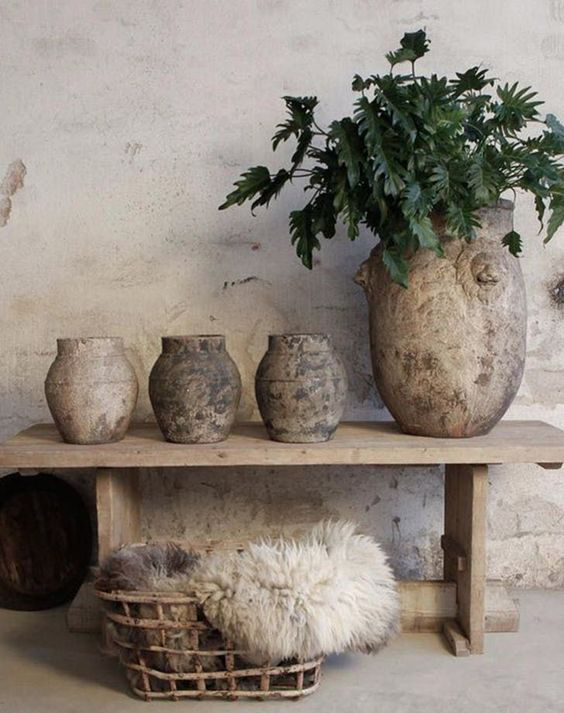

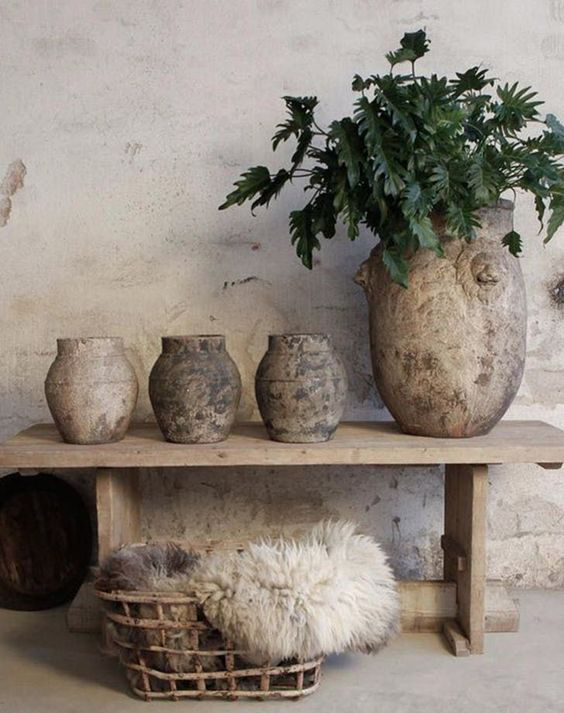

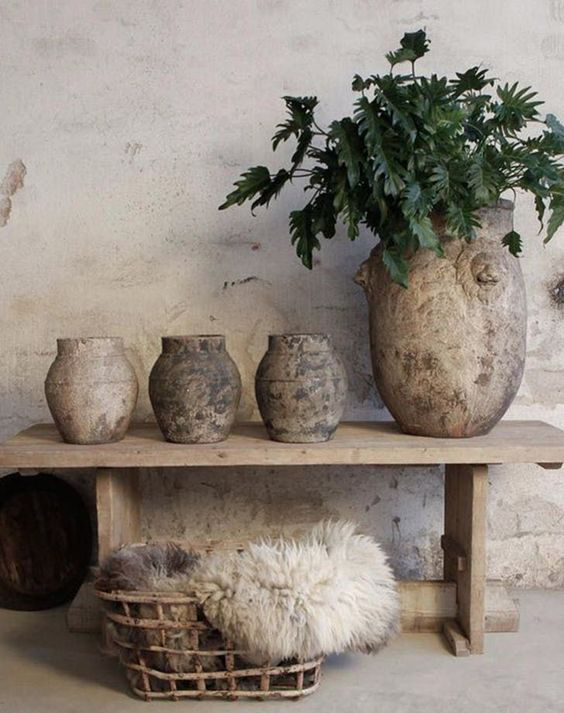

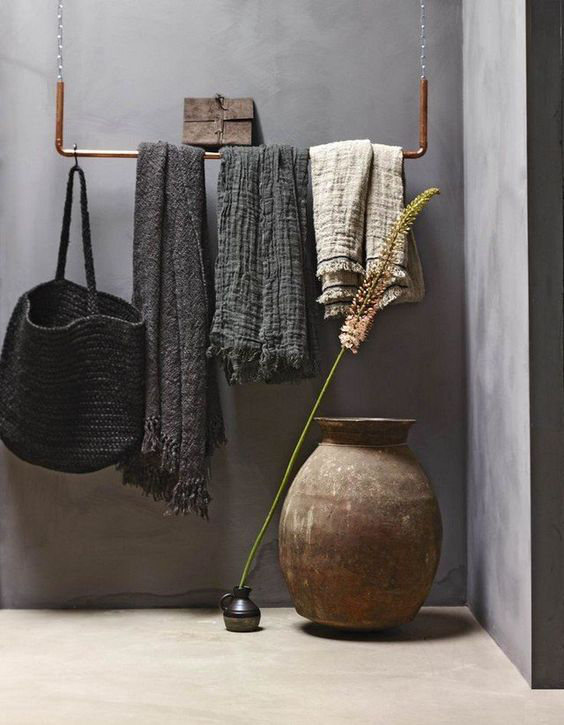

In [229]:
pots = list(path_data.glob('pots/*'))

for img_path in pots:
    # Sauter les fichiers cachés
    if not img_path.name.startswith('.'):
        display.display(Image.open(str(img_path)))

### Charger les images avec `keras.preprocessing`

`keras.preprocessing` permet d'importer facilement une image dans TensorFlow

In [124]:
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

Paramètres:

In [188]:
BATCH_SIZE = 2
IMG_HEIGHT = 224
IMG_WIDTH = 224
STEPS_PER_EPOCH = np.ceil(img_count/BATCH_SIZE)

In [195]:
# Charger les images dans TensorFlow
train_data_gen = image_generator.flow_from_directory(directory=str(path_data),
                                                     batch_size=BATCH_SIZE,
                                                     shuffle=True,
                                                     seed=21,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     classes = list(CLASS_NAMES))

Found 8 images belonging to 2 classes.


In [196]:
# Inspecter un batch
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(2):
        ax = plt.subplot(2,2,n+1) 
        plt.imshow(image_batch[n]) 
        plt.title(CLASS_NAMES[label_batch[n]==1][0].title())
        plt.axis('off')

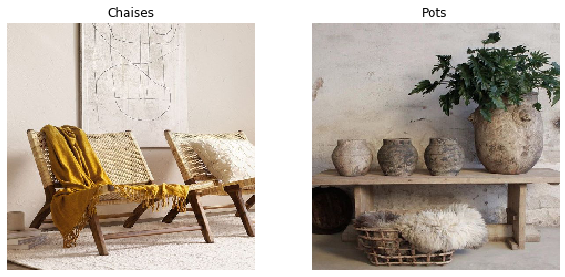

In [197]:
image_batch, label_batch = next(train_data_gen)
show_batch(image_batch, label_batch)

## Charger avec `tf.data`

La méthode précédente `keras.preprocessing` est simple mais à trois inconvénients:

1. C'est lent au chargement.
2. Il manque un contrôle fin.
3. Ce n'est pas bien intégré au reste de TensorFlow..

Pour charger les images avec tf.data.Dataset il faut d'abord créer une liste des chemins des répertoires

In [275]:
# Liste des des chemins de tous les fichiers
list_files = tf.data.Dataset.list_files('./data/img/*/*.jpg')

# Afficher les chemins des fichiers
for path_file in list_files:
    print(path_file.numpy())

b'./data/img/chaises/aa9ee48fb71de4509e1cee698e714720.jpg'
b'./data/img/pots/f80fd578ff6fadb6ffef79487fbbdc28.jpg'
b'./data/img/pots/f80fd578ff6fadb6ffef79487fbbdc28-Copy2.jpg'
b'./data/img/chaises/87131d092960d4155fb030091ba8d3c9.jpg'
b'./data/img/chaises/26ef4540e11275999e106c80e95bde12.jpg'
b'./data/img/chaises/14e42660315c88fa7afbb28afd1be0e6.jpg'
b'./data/img/pots/f80fd578ff6fadb6ffef79487fbbdc28-Copy1.jpg'
b'./data/img/pots/97ef1fb68b4d5c44e99dad6692222572.jpg'


Créer une liste contenant les noms des classes

In [251]:
path_data = pathlib.Path('./data/img')
CLASS_NAMES = np.array([path.name for path in path_data.glob('*') if not path.name.startswith('.')])
CLASS_NAMES

array(['chaises', 'pots'], dtype='<U7')

In [254]:
def get_label(file_path):
  # Convertire le chemin en plusieurs composents
  parts = tf.strings.split(file_path, os.path.sep)
  # Non de la classe qui correspond au nom du répertoire
  return parts[-2] == CLASS_NAMES 

def decode_img(img):
  # Convertire le string comprésé dans un format 3D uint8 tensor
  img = tf.image.decode_jpeg(img, channels=3) 
  # Utiliser `convert_image_dtype` pour convertire au format floats dans la plage [0,1].
  img = tf.image.convert_image_dtype(img, tf.float32) 
  # Redimentioner l'image à la taille voulue.
  return tf.image.resize(img, [IMG_WIDTH, IMG_HEIGHT])

def process_path(file_path):
    label = get_label(file_path)
    # Charger l'image brut en format string
    img = tf.io.read_file(file_path) 
    img = decode_img(img)
    return img, label

In [255]:
# Il contient des sources et des transformations expérimentales de l'ensemble de données qui peuvent être utilisées conjointement avec l'ensemble de données tf.data
AUTOTUNE = tf.data.experimental.AUTOTUNE

# Définissez `num_parallel_calls` pour que plusieurs images soient chargées/traitées en parallèle.
labeled_ds = list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [241]:
tf.strings.split('./data/img/chaises/aa9ee48fb71de4509e1cee698e714720.jpg', os.path.sep).numpy()

array([b'.', b'data', b'img', b'chaises',
       b'aa9ee48fb71de4509e1cee698e714720.jpg'], dtype=object)

In [256]:
# Afficher la forme des images et le label
for image, label in labeled_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (224, 224, 3)
Label:  [False  True]


### Etape suivante:  Basique methode pour l'entrainement

Pour entréner le model avec ces données, il faut:

* Mélanger les données.
* Créer des mini batch.
* Les minis batchs doivent être disponible le plus tôt possible.

Utiliser `tf.data` api pour facilement préparer les données avant l'entrenement do model.

In [281]:
def prepare_for_training(ds, cache=True, shuffle_buffer_size=1000):
    # Le dataset est petit, charger une fois, et garder le en mémoire.
    # utiliser `.cache(filename)` si le dataset est trop important pour être mise en cache
    if cache:
        if isinstance(cache, str):
            ds = ds.cache(cache)
        else:
            ds = ds.cache()

    ds = ds.shuffle(buffer_size=shuffle_buffer_size, seed=21) 

    # Repeat forever
    ds = ds.repeat()

    ds = ds.batch(BATCH_SIZE)

    # `prefetch` prendre les batchs pendant que le model est entréné
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

In [282]:
train_ds = prepare_for_training(labeled_ds)

image_batch, label_batch = next(iter(train_ds))

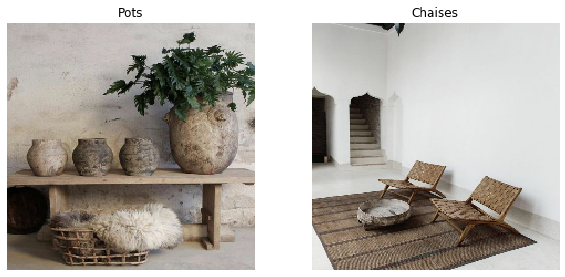

In [283]:
# Here, we define show_batch() procedure for Inspecting a batch
show_batch(image_batch.numpy(), label_batch.numpy())

# Resources 
1. Charger les données text - lien: https://www.tensorflow.org/tutorials/load_data/text
2. TF.text - lien:  https://www.tensorflow.org/tutorials/tensorflow_text/intro
3. Charger des images - https://www.tensorflow.org/tutorials/load_data/images
4. Lire les données d'un dataframe pandas - https://www.tensorflow.org/tutorials/load_data/pandas_dataframe   